# Analyse des Bias bzgl. Kein-Pfiff-Pfiff-Verhältnis für Perzeptrons

In diesem Notepad analysieren wir the Leistung eines Perzeptrons basierend auf verschiedenen
Verhältnissen der Daten ohne Pfiffe bzw. mit Pfiffe. Dies motiviert sich anhand der Tatsache, dass
in den Datenpunkten (d.h. Sekunden) insgesamt 120-mal mehr Daten enthalten sind, in denen kein Pfiff
zu hören ist, als Daten, in denen einer zu hören ist. Dies kann im Abschnitt
[*Aufteilung in Trainings- und Testdaten*](#aufteilung-in-trainings--und-testdaten) nachvollzogen
werden.

Wir kommen zum Schluss, dass ein Verhältnis von 87:1 – d.h. 87-mal mehr Daten ohne Pfiff als mit –
die höchste Präzision ergibt. Dort wird der maximale Wert von 100% erreicht. Außerdem scheint es
keine klare Korrelation zwischen dem Verhältnis und der Leistung des Modells zu geben. Dies ist
anhand der starken Oszillationen in den Graphen erkennbar.

## Feature-Matrix und Label laden

🔗 siehe [generate.ipynb](mfcc_generate.ipynb)

In [1]:
max_file_count = None
none_replacement = 'all'

RANDOM_STATE = 42

In [2]:
import numpy as np
np.set_printoptions(precision=4, suppress=True)

feature_matrix = np.load(f'feature_{max_file_count or none_replacement}.npy')
labels = np.load(f'labels_{max_file_count or none_replacement}.npy')

## Aufteilung in Trainings- und Testdaten

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.abs(feature_matrix), labels,
                                                    test_size=0.2, random_state=RANDOM_STATE)

In [4]:
print(X_train.shape)
print(X_test.shape)

(31697, 880)
(7925, 880)


In [5]:
LABEL_NO_WHISTLE = -1
LABEL_WHISTLE = 1

**Anmerkung**: Bei uns sind "Positive" (Label `+1`) die Daten, welche Pfiffe enthalten und die
"Negativen" (Label `-1`), die Daten, welche keine enthalten.

In [6]:
train_whistle_count = y_train[y_train == LABEL_WHISTLE].shape[0]
train_no_whistle_count = y_train[y_train == LABEL_NO_WHISTLE].shape[0]
factor_ratio = int(train_no_whistle_count / train_whistle_count)

print(f'#train whistle: {train_whistle_count}')
print(f'#train no whistle: {train_no_whistle_count}')
print(f'==> {factor_ratio}x more no whistle')

#train whistle: 280
#train no whistle: 31417
==> 112x more no whistle


In der letzten Zelle ist erkennbar, dass wir 280 Daten-Punkte (d.h. Sekunden) haben, in denen
ein Pfiff zu hören ist. Allerdings ist die Anzahl an Daten ohne Pfiff mit 31.417 signifikant höher –
nämlich 112-mal. Daher untersuchen wir in diesem Notepad den Bias, der durch die ungleiche
Verteilung entstehen könnte.

## Analyse des Bias bzgl. des Verhältnisses

In [7]:
from helper import reduce_and_reshuffle
from sklearn.linear_model import Perceptron
from sklearn import metrics
from tqdm import tqdm

accuracies = []
precisions = []
recalls = []
f1s = []

# test ratio from 1:1 to 112:1
ratio_range = np.arange(1, factor_ratio + 1)

for ratio in tqdm(ratio_range):
    X_tmp, y_tmp = reduce_and_reshuffle(X_train, y_train, ratio, RANDOM_STATE)
    
    model = Perceptron(n_jobs=4, random_state=42)
    model.fit(X_tmp, y_tmp)
    
    y_test_predict = model.predict(X_test)
    
    # proportion of correct predictions
    accuracies.append(metrics.accuracy_score(y_test, y_test_predict))
    
    # proportion of true positives under all positives
    precisions.append(metrics.precision_score(y_test, y_test_predict, zero_division=0))
    
    # proportion of true positives under actually positives
    recalls.append(metrics.recall_score(y_test, y_test_predict))
    
    # total performance
    f1s.append(metrics.f1_score(y_test, y_test_predict))

100%|██████████| 112/112 [01:20<00:00,  1.39it/s]


In [8]:
ratio_best_f1 = np.argmax(f1s) + 1
ratio_best_recall = np.argmax(recalls) + 1
ratio_best_precision = np.argmax(precisions) + 1
# need to add 1 since array indexing starts at 0

print(f'best f1:        {np.max(f1s):.4f} with ratio {ratio_best_f1}:1')
print(f'best recall:    {np.max(recalls):.4f} with ratio {ratio_best_recall}:1')
print(f'best precision: {np.max(precisions):.4f} with ratio {ratio_best_precision}:1')

best f1:        0.7179 with ratio 111:1
best recall:    0.9726 with ratio 2:1
best precision: 1.0000 with ratio 87:1


In [9]:
print(f'precision at best f1: {precisions[ratio_best_f1 - 1]:.2f}')
print(f'f1 at best precision: {f1s[ratio_best_precision - 1]:.2f}')

precision at best f1: 0.67
f1 at best precision: 0.03


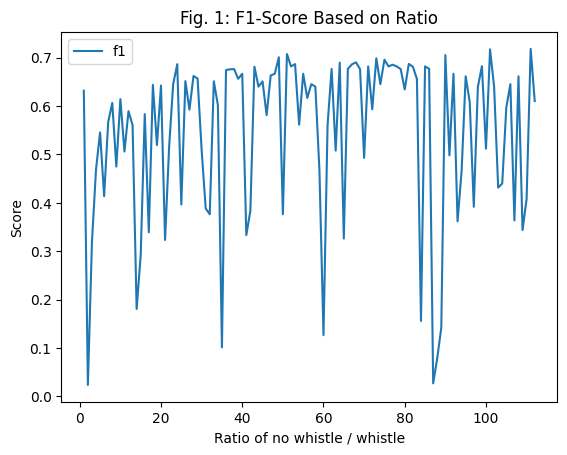

In [10]:
import matplotlib.pyplot as plt

plt.plot(ratio_range, f1s, label='f1')
plt.legend()
plt.title('Fig. 1: F1-Score Based on Ratio')
plt.xlabel('Ratio of no whistle / whistle')
plt.ylabel('Score')
plt.show()

In Fig. 1 ist zu erkennen, dass ein Verhältnis von 111:1 den besten F1-Score (0,72) ergibt.
Allerdings ist zu erkennen, dass der Graph stark oszilliert.

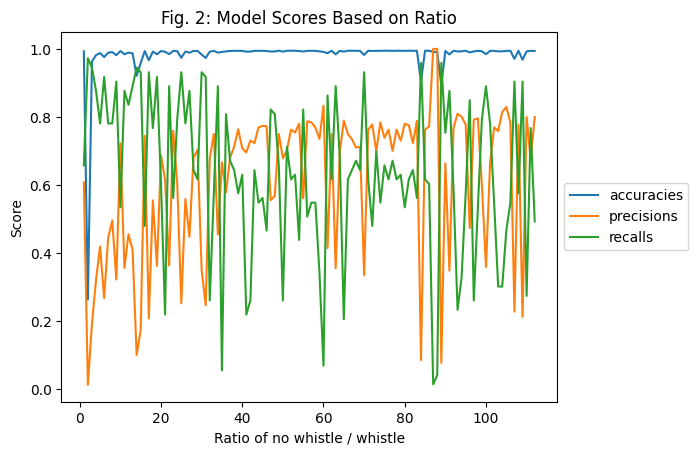

In [11]:
import matplotlib.pyplot as plt

plt.plot(ratio_range, accuracies, label='accuracies')
plt.plot(ratio_range, precisions, label='precisions')
plt.plot(ratio_range, recalls, label='recalls')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Fig. 2: Model Scores Based on Ratio')
plt.xlabel('Ratio of no whistle / whistle')
plt.ylabel('Score')
plt.show()

In Fig. 2 ist zu erkennen, dass die Genauigkeit, d.h. der Anteil der richtigen Vorhersagen, nach
den kleinen Verhältnissen bei fast allen Verhältnissen – einzelne Ausreißer ausgenommen –  nahezu 1
ist. Die Präzision und der Recall oszillieren hier erneut stark. Dennoch ist erkennbar, dass diese
beiden Metriken sich anscheinend annähernd invers verhalten.

Im Real-Szenario sieht es wie folgt aus. Es ist für die Roboter besser, einen tatsächlich
aufgetretenen Pfiff *nicht* zu erkennen, als eine Sekunde, in der kein Pfiff war, als Pfiff zu
klassifizieren. Dementsprechend wollen wir die False-Positives minimieren. Somit optimieren wir
im folgenden die Präzision anstelle des Recalls.

Der maximale Präzisionswert von 100% ergibt sich bei einem Verhältnis von 87:1. Dieses wird im
Folgenden verwendet, um das resultierende Modell zu trainieren.

## Resultierendes Modell mit bester Performance

In den vorherigen Abschnitten ist erkennbar, das für diesen Random-State ein Verhältnis von 105:1
die besten Ergebnisse bzgl. des Präzisionswertes liefert. Entsprechend wird im Folgenden ein
Perzeptron mit diesem Anteil trainiert und als Resultat dieses Notebooks gespeichert.

In [12]:
# get reduced and reshuffled training data
X_train_r, y_train_r = reduce_and_reshuffle(X_train, y_train, ratio_best_precision, RANDOM_STATE)

print(X_train_r.shape)
print(X_train_r.shape)

(24640, 880)
(24640, 880)


In [13]:
# train model
model = Perceptron(n_jobs=4, random_state=RANDOM_STATE)
model.fit(X_train_r, y_train_r)

Perceptron(n_jobs=4, random_state=42)

In [14]:
import skops.io as sio
sio.dump(model, f'perceptron.skops')

In [15]:
# generate predictions for test data
y_test_predict = model.predict(X_test)

In [16]:
print(f'#correct predictions: {y_test[y_test == y_test_predict].shape[0]}')
print(f'#false predictions:   {y_test[y_test != y_test_predict].shape[0]}')

#correct predictions: 7853
#false predictions:   72


In [17]:
print(f'#real whistles:      {y_test[y_test == LABEL_WHISTLE].shape[0]}')
print(f'#predicted whistles: {y_test_predict[y_test == LABEL_WHISTLE].shape[0]}')

#real whistles:      73
#predicted whistles: 73


In [18]:
print(f'#real no whistles:      {y_test[y_test == LABEL_NO_WHISTLE].shape[0]}')
print(f'#predicted no whistles: {y_test_predict[y_test == LABEL_NO_WHISTLE].shape[0]}')

#real no whistles:      7852
#predicted no whistles: 7852


In [19]:
# proportion of correct predictions
print(f'accuracy:  {metrics.accuracy_score(y_test, y_test_predict):.4f}')

# proportion of true positives under all positives
print(f'precision: {metrics.precision_score(y_test, y_test_predict):.4f}')

# proportion of true positives under actually positives
print(f'recall:    {metrics.recall_score(y_test, y_test_predict):.4f}')

# total performance
print(f'f1:        {metrics.f1_score(y_test, y_test_predict):.4f}')

accuracy:  0.9909
precision: 1.0000
recall:    0.0137
f1:        0.0270


In [20]:
print(metrics.classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

          -1       0.99      1.00      1.00      7852
           1       1.00      0.01      0.03        73

    accuracy                           0.99      7925
   macro avg       1.00      0.51      0.51      7925
weighted avg       0.99      0.99      0.99      7925



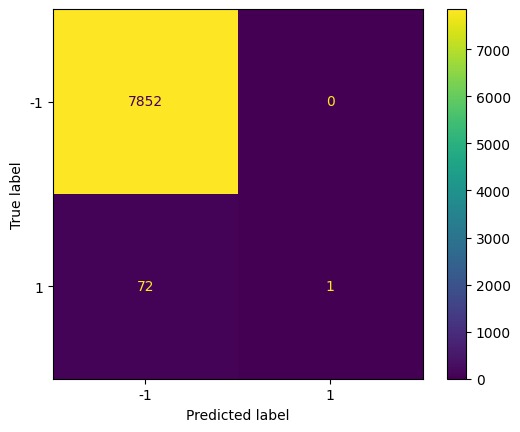

In [21]:
_ = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

In [22]:
# relative confusion matrix
print(metrics.confusion_matrix(y_test, y_test_predict) / y_test.shape[0])

[[0.9908 0.    ]
 [0.0091 0.0001]]
